### Import Library
We are going to use pandas to easily control the flow of data to be used for analysis later on. Then to easily optimize our analysis we are going to use the analysis function from Scipy

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib as plt
import seaborn as sns
from scipy.linalg import cholesky, solve_triangular, cho_solve, cho_factor
from scipy.linalg import solve
from scipy.optimize import minimize

### Import Historical Stock Data
for this first prototype we are going to use strictly 3 stocks which is BBCA, ITMG, & MCAS

In [2]:
# mount data to data frame
df_bbca = pd.read_csv('BBCA.JK.csv')
df_itmg = pd.read_csv('ITMG.JK.csv')
df_mcas = pd.read_csv('MCAS.JK.csv')

In [3]:
# Filter the column that is used

df_bbca = df_bbca[['Date', 'Symbol', 'Close','Return+1']]
df_itmg = df_itmg[['Date', 'Symbol', 'Close','Return+1']]
df_mcas = df_mcas[['Date', 'Symbol', 'Close','Return+1']]

### Extract Risk and Return 
Geomean for Return calculation
Variance for Risk calculation

In [4]:
# calculate Geometric Mean of Return

def geomeanReturn(df):
    geomean = (stats.gmean(df['Return+1'].iloc[2:-1])) - 1
    return geomean

bbca_geomean = geomeanReturn(df_bbca)
itmg_geomean = geomeanReturn(df_itmg)
mcas_geomean = geomeanReturn(df_mcas)

In [5]:
# calculate variance of Return as Risk

def varianceRisk(df):
    variance = df['Return+1'].iloc[2:-1].var()
    return variance

bbca_var = varianceRisk(df_bbca)
itmg_var = varianceRisk(df_itmg)
mcas_var = varianceRisk(df_mcas)


In [6]:
# calculate covariance of Return for each pair of stocks

def covarStock(df1,df2):
    covar = np.cov(df1['Return+1'], df2['Return+1'])
    return covar[0][1]

cov_bbca_itmg = covarStock(df_bbca,df_itmg)
cov_bbca_mcas = covarStock(df_bbca,df_mcas)
cov_itmg_mcas = covarStock(df_itmg,df_mcas)

### Initiate table for Model
in This section we will create a fitting table to initiate the Modern Portfolio Theory Analysis

In [7]:
# Here we create a random distribution of stocks to populate the scatter plot

import random
def generateDist(n):
    arrN = [None] * n 
    arrX, arrY, arrZ = []  , [] , []
    for i in range(0,n):
        arrN[i] = random.randrange(100)

        x = arrN[i]
        arrX.append((x/100))

        y = random.randrange(100-arrN[i])
        arrY.append((y/100))

        z = 100 - x - y
        arrZ.append((z/100))
    df = pd.DataFrame(
    {'asset_1': arrX,
     'asset_2': arrY,
     'asset_3': arrZ
    })
    return df
df_dist = generateDist(100)

In [8]:
df_dist['a1square'] = df_dist.asset_1 ** 2
df_dist['a2square'] = df_dist.asset_2 ** 2
df_dist['a3square'] = df_dist.asset_3 ** 2

#### Create new Risk & Return column

In [9]:
df_dist["risk"] = (df_dist.a1square * bbca_var) + (df_dist.a2square * itmg_var) + (df_dist.a3square * mcas_var) + (2*(df_dist.asset_1 * df_dist.asset_2 * cov_bbca_itmg)) + (2*(df_dist.asset_1 * df_dist.asset_3 * cov_bbca_mcas)) + (2*(df_dist.asset_3 * df_dist.asset_2 * cov_itmg_mcas))

In [10]:
df_dist["return"] = (df_dist.asset_1 * bbca_geomean) + (df_dist.asset_2 * itmg_geomean) + (df_dist.asset_3 * mcas_geomean)

#### Input the desired risk

In [11]:
minrisk = float(input())

### Visualize the possible distribution of Stocks

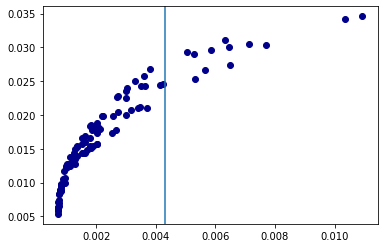

In [12]:
plt.pyplot.scatter(df_dist.risk, df_dist['return'], c="DarkBlue")
plt.pyplot.axvline(x = minrisk)

### Optimization Model
Using all the data regarding the risk input by the user, geomean of each stock's return, and the risk for each stock's return, we now create an equation for python to optimize with the desired constraints

In [13]:
def f(x):
    return -(x[0]*bbca_geomean + x[1]*itmg_geomean + x[2] * mcas_geomean)

In [14]:
# 1st Constraint

# create bounds for optimization (each distribution must be in range from 0.0 - 1.0)

b = (0.0 , 1.0)
bnds = (b,b,b)

In [15]:
# 2nd Constraint

# risk must exactly be the same as the one user inputted

# the sum of the distribution must be equal to one

cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0] + x[1] + x[2] - 1,
          ((x[0] * bbca_var) + (x[1] * itmg_var) + (x[2] * mcas_var) + 
          (2*(x[0] * x[1] * cov_bbca_itmg)) + (2*(x[0] * x[2] * cov_bbca_mcas)) + (2*(x[1] * x[2] * cov_itmg_mcas)) - minrisk)])})

In [16]:
# pick the first row of distribution as initial value
x0 = np.array([df_dist.asset_1[0],df_dist.asset_2[0],df_dist.asset_3[0]])

# start optimization
res = minimize(f, x0, bounds = bnds, constraints=cons)

In [17]:
print('BBCA :', str(100 * (round(res.x[0],2))) , '%')
print('ITMG :', str(100 * round(res.x[1],2)) , '%')
print('MCAS :', str(100 * round(res.x[2],2)) , '%')

BBCA : 20.0 %
ITMG : 80.0 %
MCAS : 0.0 %


In [18]:
print('Maximum Return : ', str(100 * round((-1 * res.fun), 2)), '%')

Maximum Return :  0.02
